## Greenland Rising 
In Greenland - proximate to the large rapidly changing Greenland ice sheet - the coast is rising at rates of up to 2.3cm/yr, and the bathymetry in coastal environments will shoal rapidly. Much research has focused on the changing Greenland Ice Sheet but little on the impact on coastal communities: their social and built environment. Aasiaat, on Disko Bay, is a hub for shrimp and crab fishing, shipbuilding and tourism and has the potential to become a minerals hub in the future. A vibrant maritime community with villages and infrastructure an adjacent islands, Aasiaat has relatively poorly constrained bathymetry in surrounding fjords and is experiencing moderate uplift (6 mm/year). Other study areas include Kullorsuaq (10.5 mm/yr), one of Greenland oldest communities, and Nuuk (3.3 mm/yr), Greenland’s capital and largest population center. Our area of study today will be Aasiaat because it is middling. 

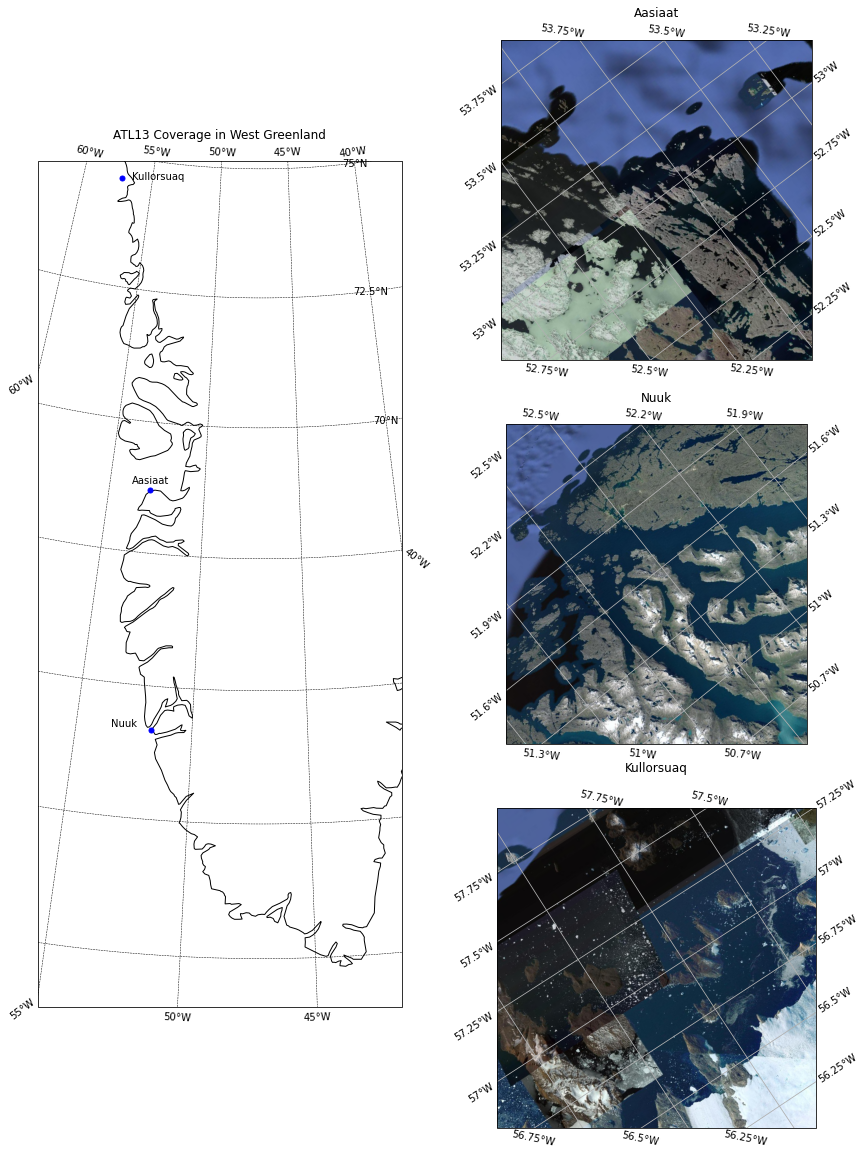

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import cartopy.io.img_tiles as cimgt 
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize=(30, 20), tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax = fig.add_subplot(gs[:, 0], projection=ccrs.NorthPolarStereo(central_longitude=-47))
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-55, -42, 59, 75], crs=ccrs.PlateCarree())
ax.set_title('ATL13 Coverage in West Greenland')
# for cartopy version 0.18 only
ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='black')
ax.plot(-57.229479, 74.578753,'bo', markersize=5, transform=ccrs.Geodetic())
ax.text(-56.5, 74.6, 'Kullorsuaq', transform=ccrs.Geodetic())
ax.plot(-52.84,68.7, 'bo', markersize=5, transform=ccrs.Geodetic())
ax.text(-53.84, 68.8, 'Aasiaat', transform=ccrs.Geodetic())
ax.plot(-51.748,64.175984, 'bo', markersize=5, transform=ccrs.Geodetic())
ax.text(-53.5, 64.18, 'Nuuk', transform=ccrs.Geodetic())

extent = [[-53.5, -52.5, 68.5, 68.8], [-52.22, -50.89, 64.0, 64.34], [-57.54, -56.54, 74.54, 74.8]] 
town = ['Aasiaat', 'Nuuk', 'Kullorsuaq']
for i in range(3):
    ax = fig.add_subplot(gs[i, 1], projection=ccrs.NorthPolarStereo())
    ax.set_title(town[i])
    gl = ax.gridlines(draw_labels=True)
    #gl.labels_top = gl.labels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    request = cimgt.GoogleTiles(style = 'satellite')
    ax.set_extent(extent[i])

    ax.add_image(request, 10)
    
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.show()

### ICESat-2

ICESat-2 launched in 2018 and carries onboard a single instrument – the Advanced Topographic Laser Altimeter System (ATLAS), which transmits laser pulses at a frequency of 532 nm. ATLAS measures travel time of these pulses to derive the distance between the platform and Earth’s surface, which gives us an estimate of the Earth's surface elevation with respect to a reference surface. ICESat-2's polar orbit pattern results in a higher density of shots within the polar regions, with a focus on the cryosphere as the name would imply. While ICESat-2's main mission is to measure "ice sheet elevation and sea ice thickness, as well as land topography, vegetation characteristics, and clouds," the green frequency of ATLAS created a happy side effect - the ability to penetrate water bodies and return bathymetric measurements. 

### Use for bathymetry
The 532 nm wavelength both scatters and absorbs at depths to several tens of meters depending on water turbidity and albedo of the underlying substrate - estimated up to 80% of secchi depth. Because bathymetry was not the original intention of ATLAS, most of the algorithms ICESat-2 uses for data products higher than ATL03 categorize bathymetry as "noise" and filter them out during the corrections process. However, the recently released ATL13 Inland Water Body Height Data product provides algorithm-derived estimates of nearshore bathymetry. This depth is derived as the difference between the upper and lower limits above coarse water surface - meaning that the algorithm will likely fail to identify small-scale bathymetric features and steep coasts - both of which are present around Greenland - as well as potentially over-estimate presence of bathymetry in the noise of the ocean surface. 

In [102]:
import h5py
import numpy as np
import pyproj
from pathlib import Path
from astropy.time import Time
import pandas as pd
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib notebook

### IS2 data organization and retrieval 

File naming convention
ATL06_20181120202321_08130101_001_01.h5

[ATL03]_[yyyy][mmdd][hhmmss]_[RGT][cc][ss]_[rrr]_[vv].h5


In summary, each individual granule is defined by its product level AND reference ground track AND date of retrieval AND cycle AND region AND ascending status. Within each file, variables are further segmented based on beam. Further, the internal organization of variables varies naming convention and placement from product to product - ATL03 lat is not in the same directory or the same name as in ATL13. This makes it very difficult to organize IC2 data in efficient code. Therefore, I decided to subset each file for spatial extent and variable name - and then create new files segmented by beam. 

In [103]:
def reduceatl13(fname, bbox=None): #modified from IS2 hackweek 2020  notebook by Fernando Paolo https://github.com/ICESAT-2HackWeek/intro-hdf5

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):

        data = {}
    
        try:
            with h5py.File(fname, 'r') as fi:
                
                data['lat'] = fi[g+'/segment_lat'][:]
                data['lon'] = fi[g+'/segment_lon'][:]
                data['dt'] = fi[g+'/delta_time'][:]
                data['depths']= fi[g+'/water_depth'][:]
                data['q_flag'] = fi[g+'/qf_bias_em'][:]
                #rgt = fi[g+'/rgt'][:]                           # single value
                t_ref = fi['ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
#                 fix time
                IS2_timestart = calendar.timegm(time.strptime('Jan 1, 2018 @ 00:00:00 UTC', '%b %d, %Y @ %H:%M:%S UTC'))
                time_start = fi.attrs['time_coverage_start']  
                dtseconds = np.median(dt)
                tp = time.gmtime((IS2_timestart + dtseconds))
                IS2time = '%04d-%02d-%02d %02d:%02d:%02d UTC' % (tp.tm_year, tp.tm_mon, tp.tm_mday, tp.tm_hour, tp.tm_min, tp.tm_sec)
                data['time'] = IS2time
        except Exception as e:
            print(f'g = {g}, exception = {e}')
            print()
            continue
        
        # region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (data['lon'] >= lonmin) & (data['lon'] <= lonmax) & \
                        (data['lat'] >= latmin) & (data['lat'] <= latmax)
        else:
            bbox_mask = np.ones_like(data['lat'], dtype=bool)  # get all
            
        # mask bad data and spatial extent
        mask = (data['q_flag'] == 0) & (np.abs(data['depths']) < 10e3) & (np.abs(data['depths']) > 0) & (bbox_mask == 1)
        
        # update data variables
        for k, v in data.items(): data[k] = v[mask]

        # define output dir and file
        outdir = Path('/home/cbrayton/icesat2/data/aasiaat/ATL13/beam') 
        fname = Path(fname)
        outdir.mkdir(exist_ok=True)
        outfile = outdir / fname.name.replace('.h5', '_' + g[1:] + '.h5')
        
        # save variables
        with h5py.File(outfile, 'w') as fo:
            for k, v in data.items(): fo[k] = v
            print('out ->', outfile)

In [104]:
outdir = Path('./data') 
def read_h5(fname, vnames=[]):
    """Read a list of vars [v1, v2, ..] -> 2D."""
    with h5py.File(fname, 'r') as f:
        return np.column_stack([f[v][()] for v in vnames])

In [105]:
# list of files to plot
files = list(outdir.glob('*.h5'))

# variables to plot
vnames = ['lon', 'lat', 'depths']
#vnames = ['x', 'y', 'h_li']

# vist with one dataframe per file
dfs = [pd.DataFrame(read_h5(f, vnames), columns=vnames) for f in files]

# single dataframe
df = pd.concat(dfs)
#df.to_dask_array(lengths=True), if df larger than memory

In [106]:
df.head()

,lon,lat,depths
0,-52.163449,68.789134,5.852746
1,-52.163817,68.788049,5.852746
2,-52.164181,68.786962,5.852746
3,-52.164537,68.785896,5.852746
4,-52.164901,68.784826,5.852746


The coastline feature of cartopy is not high enough resolution to show the level of detail that makes Aasiaat's coastlines so intricate and interesting for bathymetry studies. A high resolution coastline shapefile was rendered using NOAA's Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG) in ArcGIS. 

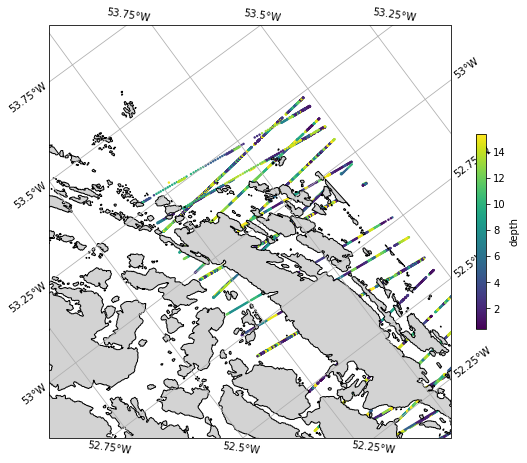

In [107]:
extent = [-53.5, -52.5, 68.5, 68.8]
fig = plt.figure(figsize=(9, 9), tight_layout=True)
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
gl = ax.gridlines(draw_labels=True)
gl.labels_top = gl.labels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_extent(extent)

shp = shapereader.Reader('./data/Aasiaat_t3.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
                      edgecolor='black')
    
plt.scatter(df['lon'], df['lat'],c=df['depths'],s=2, cmap = 'viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='depth', shrink=0.4)
plt.show()

This figure shows the approximate ATL13-derived water depths around Aasiaat for every rgt returned on cycle 02. This coverage is impressive, with depths up to 14 m. However, we need to visually compare this derived bathymetry to other products to verify if these results are reasonable to see if our human eyes can recognize the bathymetry that this algorithm "sees." Because ATL03, ATL06, and ATL08 products tend to be large, we will use the OpenAltimetry API to download these datasets. 

In [108]:
# gather different data products from OpenAltimetry API to compare products 
def OAcollect(beam, track, date, latlims, lonlims):

        url = 'https://openaltimetry.org/data/api/icesat2/atlXX?'
        url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={track}&beamName={beam}'.format(
                    date=date,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1],maxy=latlims[1],track=track,beam=beam)
        url += '&outputFormat=json&client=jupyter'

        url = url
        date = date
        track = track
        beam = beam
        latlims = latlims
        lonlims = lonlims
        print('OpenAltimetry API URL:', url)
        print('Date:', date)
        print('Track:', track)
        print('Beam:', beam)
        print('Latitude limits:', latlims)
        print('Longitude limits:', lonlims)
        return url
def OArequest(url):
    import pandas as pd
    import json
    import requests

    print('---> requesting ATL03 data...',end='')
    product = 'atl03'
    request_url = url.replace('atlXX',product)
    data = requests.get(request_url).json()
    lat, lon, h, confs = [], [], [], []
    for beam in data:
        for confidence in beam['series']:
            for p in confidence['data']:
                confs.append(confidence['name'])
                lat.append(p[0])
                lon.append(p[1])
                h.append(p[2])
    atl03 = pd.DataFrame(list(zip(lat,lon,h,confs)), columns = ['lat','lon','h','conf'])
    print(' Done.')

    print('---> requesting ATL06 data...',end='')
    product = 'atl06'
    request_url = url.replace('atlXX',product)
    data = requests.get(request_url).json()
    atl06 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
    print(' Done.')

    print('---> requesting ATL08 data...',end='')
    product = 'atl08'
    request_url = url.replace('atlXX',product)
    data = requests.get(request_url).json()
    atl08 = pd.DataFrame(data['series'][0]['lat_lon_elev_canopy'], columns = ['lat','lon','h','canopy'])
    print(' Done.')
    
    return atl03, atl06, atl08

In [109]:
mydata = OAcollect(beam='gt1l', track = '0026', date = '2018-12-30', latlims=[68.5, 68.8], lonlims=[-53.5, -52.5])
data = OArequest(mydata)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2018-12-30&minx=-53.5&miny=68.5&maxx=-52.5&maxy=68.8&trackId=0026&beamName=gt1l&outputFormat=json&client=jupyter
Date: 2018-12-30
Track: 0026
Beam: gt1l
Latitude limits: [68.5, 68.8]
Longitude limits: [-53.5, -52.5]
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


In [110]:
data

(             lat        lon           h   conf
 0      68.799306 -52.597497   74.261925  Noise
 1      68.798351 -52.597748 -121.074500  Noise
 2      68.798251 -52.597822    3.170199  Noise
 3      68.797714 -52.598000   -8.319308  Noise
 4      68.796401 -52.598480   55.385933  Noise
 ...          ...        ...         ...    ...
 49557  68.500073 -52.697914   28.971468   High
 49558  68.500067 -52.697915   24.732088   High
 49559  68.500061 -52.697918   29.037817   High
 49560  68.500061 -52.697917   24.797947   High
 49561  68.500054 -52.697920   26.389147   High
 
 [49562 rows x 4 columns],
             lat        lon          h
 0     68.799844 -52.597301  22.445671
 1     68.799666 -52.597361  22.461845
 2     68.799488 -52.597421  22.444730
 3     68.799309 -52.597479  22.440104
 4     68.799131 -52.597538  22.448387
 ...         ...        ...        ...
 1671  68.500762 -52.697683  28.664860
 1672  68.500584 -52.697743  30.396732
 1673  68.500406 -52.697803  31.372034
 1674

In [111]:
root_dir = './data'
f=glob.glob(os.path.join(root_dir, 'ATL13_20181230014249_00250201_003_01_gt1l.h5'))[0]

# variables to plot
vnames = ['lon', 'lat', 'depths', 'ice_flag', 'qf_cloud', 'qf_subsurf_anomaly']
dfs = pd.DataFrame(read_h5(f, vnames), columns=vnames)


In [112]:
dfs

,lon,lat,depths,ice_flag,qf_cloud,qf_subsurf_anomaly
0,-52.601206,68.788322,14.246684,0.0,2.147484e+09,3.0
1,-52.601266,68.788153,14.246684,0.0,2.147484e+09,3.0
2,-52.601331,68.787965,14.246684,0.0,2.147484e+09,3.0
3,-52.601392,68.787789,14.246684,0.0,2.147484e+09,3.0
4,-52.601457,68.787601,14.246684,0.0,2.147484e+09,3.0
...,...,...,...,...,...,...
606,-52.674339,68.571013,12.827548,0.0,2.147484e+09,1.0
607,-52.674421,68.570761,12.827548,0.0,2.147484e+09,1.0
608,-52.674499,68.570521,12.827548,0.0,2.147484e+09,1.0
609,-52.674578,68.570274,12.827548,0.0,2.147484e+09,1.0


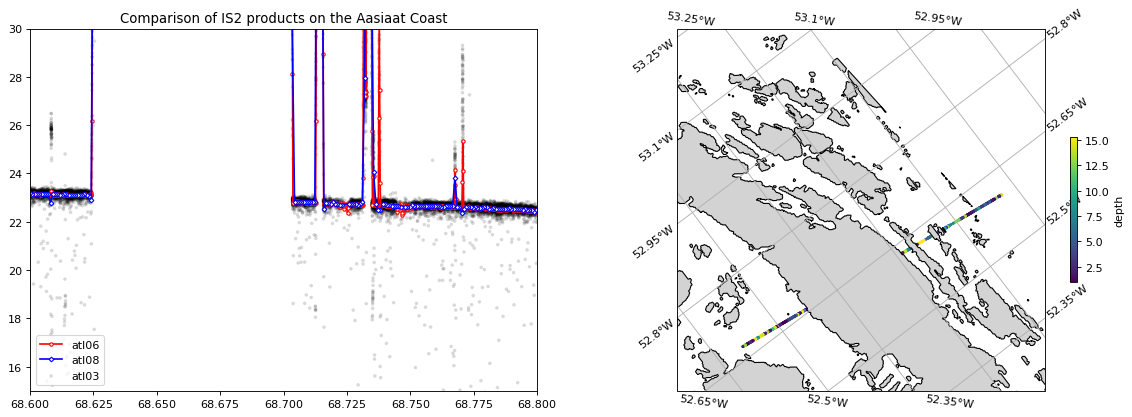

In [113]:
extent = [-53, -52.5, 68.6, 68.8]
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k', tight_layout=True)
ax1 = fig.add_subplot(121)
title = 'Comparison of IS2 products on the Aasiaat Coast'
atl03_plot = ax1.scatter(data[0]['lat'],data[0]['h'],s=10,c='k',alpha=0.15,edgecolors='none',label='atl03')
atl06_plot = ax1.plot(data[1]['lat'],data[1]['h'],c='r',ls='-',marker='o',ms=3,mfc='w',mec='r',label='atl06')
atl08_plot = ax1.plot(data[2]['lat'],data[2]['h'],c='b',ls='-',marker='D',ms=3,mfc='w',mec='b',label='atl08')
ax1.set_title(title)
ax1.set_xlim([68.6, 68.8])
ax1.set_ylim([15, 30])
ax1.legend(loc='lower left')

ax2 = fig.add_subplot(122, projection=ccrs.NorthPolarStereo())
gl = ax2.gridlines(draw_labels=True)
gl.labels_top = gl.labels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent(extent)

shp = shapereader.Reader('./data/Aasiaat_t3.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax2.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
                      edgecolor='black')
plt.scatter(dfs['lon'], dfs['lat'],c=dfs['depths'],s=3, cmap = 'viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='depth', shrink=0.4)
plt.show()    

There are clear parallels in these plots - the large island is visible in the cloud, as are the other islands where ATL13 crosses land. While there are a few signs of bathymetry in the ATL03/06/08 cloud, most likely at ~68.722, these signals are not strong and could be part of the overall noise. While the ATL13 data was filtered by the overall "quality flag" f, we can take a look at other confounding factors such as turbidity/ice/silt/atmospheric interference/etc. that might skew the ATL13 results - despite the fact that we filtered based on a quality flag that excludes data likely influenced by blowing snow, clouds, etc. 

Text(0.5, 1.0, 'Full ATL03 cloud w/ confidence level')

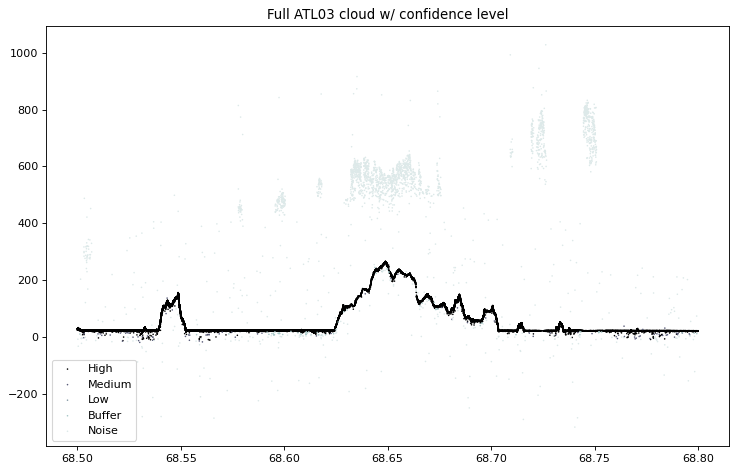

In [114]:
import matplotlib
extent = [-53, -52.5, 68.6, 68.8]
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k', tight_layout=True)
ax1 = fig.add_subplot(121)
title = 'Full ATL03 cloud w/ confidence level'
atl03 = data[0]

confslvl = ['Noise','Buffer','Low','Medium','High']
cmap = matplotlib.cm.get_cmap('bone')
confcols = cmap([0.9,0.75,0.6,0.4,0])

for confs in range(len(confslvl))[::-1]:
    select_conf = atl03['conf']==confslvl[confs]
    confcol = confcols[confs]
    ax1.scatter(atl03['lat'][select_conf], atl03['h'][select_conf], s=2, c=[confcol], 
                         alpha=1, edgecolors='none')
    #ax1.scatter(0, 0, s=25, c=[confcol], alpha=1, edgecolors='none',label=confs_lvl[confs]) # for legend
ax1.legend(confslvl[::-1], loc='lower left')
ax1.set_title(title)


Included in the noise is likely clouds. Clouds are filtered out of the ATL13 data but still impact the algorithm to determine depth underneath the cloudy areas. 

In [115]:
atl03

,lat,lon,h,conf
0,68.799306,-52.597497,74.261925,Noise
1,68.798351,-52.597748,-121.074500,Noise
2,68.798251,-52.597822,3.170199,Noise
3,68.797714,-52.598000,-8.319308,Noise
4,68.796401,-52.598480,55.385933,Noise
...,...,...,...,...
49557,68.500073,-52.697914,28.971468,High
49558,68.500067,-52.697915,24.732088,High
49559,68.500061,-52.697918,29.037817,High
49560,68.500061,-52.697917,24.797947,High


The variable 'qf_subsurf_anomaly' describes the likelihood that the bottom or other subsurface anomaly is bottom based on the threshold value at which an anomaly was found. 1 = Subsurface anomaly due to bottom likely; 2 = Subsurface signal may indicate bottom or other anomaly; 3 = Possible subsurface anomaly; invalid = No subsurface anomaly detected

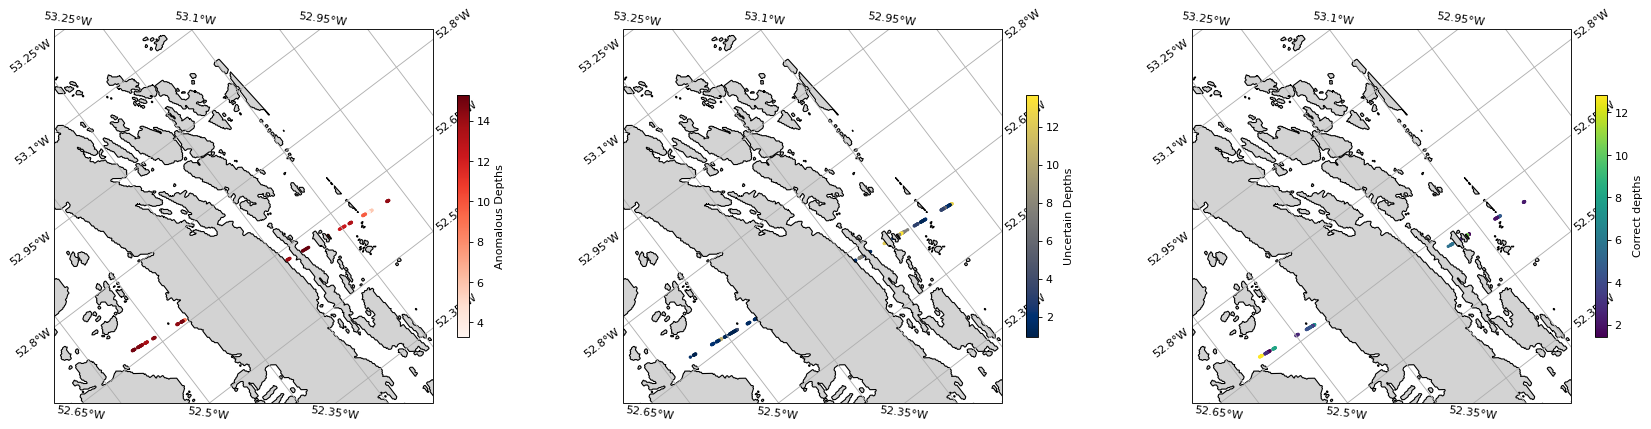

In [116]:
fig = plt.figure(figsize=(26, 10), dpi= 80, facecolor='w', edgecolor='k', tight_layout=True)
ax1 = fig.add_subplot(131, projection=ccrs.NorthPolarStereo())
gl = ax1.gridlines(draw_labels=True)
gl.labels_top = gl.labels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent(extent)

mask1 = (dfs['qf_subsurf_anomaly'] == 3)
dfs['anomaly'] = dfs['depths'][mask1] 

shp = shapereader.Reader('./data/Aasiaat_t3.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax1.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
                      edgecolor='black')
plt.scatter(dfs['lon'], dfs['lat'],c=dfs['anomaly'],s=4, cmap = 'Reds', transform=ccrs.PlateCarree())
plt.colorbar(label='Anomalous Depths', shrink=0.4)

#apply mask to show which parts of track are anomalies 
mask1 = (dfs['qf_subsurf_anomaly'] == 2)
dfs['depths_uncertain'] = dfs['depths'][mask1]

ax2 = fig.add_subplot(132, projection=ccrs.NorthPolarStereo())
gl = ax2.gridlines(draw_labels=True)
gl.labels_top = gl.labels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent(extent)

shp = shapereader.Reader('./data/Aasiaat_t3.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax2.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
                      edgecolor='black')
plt.scatter(dfs['lon'], dfs['lat'],c=dfs['depths_uncertain'],s=4, cmap = 'cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Uncertain Depths', shrink=0.4)

mask2 = (dfs['qf_subsurf_anomaly'] == 1)
dfs['depths_correct'] = dfs['depths'][mask2]

ax3 = fig.add_subplot(133, projection=ccrs.NorthPolarStereo())
gl = ax3.gridlines(draw_labels=True)
gl.labels_top = gl.labels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax3.set_extent(extent)

shp = shapereader.Reader('./data/Aasiaat_t3.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax3.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
                      edgecolor='black')
plt.scatter(dfs['lon'], dfs['lat'],c=dfs['depths_correct'],s=4, cmap = 'viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='Correct depths', shrink=0.4)


plt.show()

A large fraction of the heights derived by the ATL13 product are either likely or possibly anomalies, meaning that IS2 ATL13 has limited use around Aasiaat - and likely for the rest of our study regions due to the turbidity of the water, relatively un-reflective substrate, and bad weather. 